# Functions to transform the output of the model (masks) into .roi files

In [14]:
import cv2 

def contour_from_mask(mask):
    # cv2.findContours only works on binary image, hence the following two lines
#     imgray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) 
#     _, thresh = cv2.threshold(imgray, 100, 255, 0)
    thresh = mask.astype('uint8')
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours[0] #there should be only one contour

def roi_from_contour(name, cnt):
    x = cnt[:,0,0]
    y = cnt[:,0,1]
    dict_data = {
        'type':'freehand',
        'x': list(x),
        'y': list(y),
        'n':len(x),
        'width':0,
        'name':name,
        'position':0
    }
    roi = { name : dict_data }
    return(roi)

# TO DO
# def create_roi_file(roi):
# see file format https://imagej.nih.gov/ij/developer/source/ij/io/RoiDecoder.java.html
    

In [26]:
import skimage.io
DIR = 'C:\\Users\\Fred\\Downloads/'
mask = skimage.io.imread(DIR+'R29 VEGF 2_15.0xC3-5.png')

In [27]:
roi1 = roi_from_contour('R29 VEGF 2_15.0xC3-5',contour_from_mask(mask))

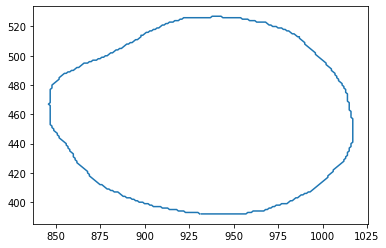

In [28]:
import matplotlib.pyplot as plt
for name in roi1:
    plt.plot(roi1[name]['x'],roi1[name]['y'])

In [123]:
def roi_save(roi,dir_path):
# inspired from https://gist.github.com/dabasler/c4b885164db5c845cd20688f4a00cab0

    for name in roi:
        n = roi[name]['n'] # number of points
        x = roi[name]['x'] # x coordinates
        y = roi[name]['y'] # y coordinates
    
    x = [int(xi) for xi in x] # make sure that x is a list of python int type (not numpy.int type)
    y = [int(yi) for yi in y] # make sure that x is a list of python int type (not numpy.int type)
        
    data=bytearray()       # file buffer

    # HEADER 1
    data += "Iout".encode()         # file always starts with 'Iout'
    data += (227).to_bytes(2,'big') # (int16) version number = 227
    data += (7).to_bytes(1,'big')   # (int8) type of roi - 7 means 'freehand' 
    data += (0).to_bytes(1,'big')   # (int8) code for subtype - 0 here
    top = min(y)                    # need to convert to python int because numpy int doesn't work with to_bytes
    data += (top).to_bytes(2,'big') # (int16) lower y coordinates
    left = min(x)
    data += (left).to_bytes(2,'big')# (int16) lower x coordinates
    bottom = max(y)
    data += (bottom).to_bytes(2,'big')# (int16) upper y coordinates
    right = max(x)
    data += (right).to_bytes(2,'big') # (int16) upper x coordinates
    data += n.to_bytes(2,'big')     # (int16) total number of coordinates
    for i in range(42):             # unused bytes
        data += b'\x00'
    h2offset_index = len(data)
    data += (0).to_bytes(4,'big')   # (int32) header2 offset - set to 0 for now, will change at the end

    # COORDINATES
    for x_i in x: # (int16) array of x coordinates, with offset
        data += (x_i - left).to_bytes(2,'big')
    for y_i in y: # (int16) array of y coordinates, with offset
        data += (y_i - top).to_bytes(2,'big')

    # HEADER2
    h2offset = len(data)
    for i in range(16):             # header2 start and C,Z,T positions - unused bytes
        data += b'\x00'
    nameoffset_index = len(data)
    data += (0).to_bytes(4,'big')   # (int32) name offset - set to 0 for now, will change at the end
    data += (len(name)).to_bytes(4,'big')  # (int32) name length
    for i in range(40):             # unused bytes
        data += b'\x00'

    # FILE NAME
    nameoffset = len(data)
    for c in name:                  # name of the roi file, encoded every other byte
        data += b'\x00' + c.encode()
    
    # write offsets retrospectively
    data[h2offset_index:h2offset_index+4]=(h2offset).to_bytes(4,'big')
    data[nameoffset_index:nameoffset_index+4]=(nameoffset).to_bytes(4,'big')

    with open(os.path.join(dir_path,name+'.roi'), "wb") as file:
        file.write(data)

In [128]:
import skimage.io
import os
DIR = 'C:\\Users\\Fred\\Downloads/'
for i in range(9):
    mask = skimage.io.imread(DIR+'R29 VEGF 2_15.0xC3-'+str(i)+'.png')
    roi = roi_from_contour('R29 VEGF 2_15.0xC3-'+str(i),contour_from_mask(mask))
    roi_save(roi,DIR)